## Model Architecture

The first model here is a multi-layer architecture consisting of alternating separable and normal convolutions and nonlinearities. These layers are followed by fully connected layers leading into a sigmoid. The model follows the architecture similar to VGG16 by K. Simonyan and A. Zisserman.

This model achieves a peak performance of about 94% accuracy within 11 minutes of training time on a GPU. It consists of 2,313,441 learnable parameters.

## Load libraries

In [ ]:
# Toolbox
from pathlib import Path
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, ReLU, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras
import tensorflow as tf
import tensorflow.keras
import cv2

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Misc
import os
import warnings
warnings.filterwarnings(action='ignore')

# Preset data display
pd.options.display.max_seq_items = 1000
pd.options.display.max_rows =1000
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 500)

# Set notebook colors and palette
flatui = ['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']
sns.set_palette(flatui)
sns.palplot(sns.color_palette(flatui))
sns.set_style('white')
sns.set_color_codes(palette='deep')
# Favorite code to use: #34995e

# Setting seeds for reproducibility
seed = 100
np.random.seed(seed)
tf.set_random_seed(seed)

In [ ]:
print('These are the current versions working for me as of 2019-08-07')
print(f"OpenCV Version: {cv2.__version__}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"TensorFlow Keras Version: {tensorflow.keras.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print("TensorFlow-GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print(f"TensorFlow CUDA: {tf.test.is_built_with_cuda()}")
print(f"Tensorflow GPU Device Currently Activated: {tf.test.gpu_device_name()}")
print(f"Keras GPU: {keras.backend.tensorflow_backend._get_available_gpus()}")
print()
print(f"TF Session: {tf.Session()}")
print()
print(f"Python {sys.version}")

## Define functions

In [ ]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get Values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()


## Set directory

In [ ]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\07-pneunomia-radiograph-imaging\\images'
os.chdir(PATH)
os.getcwd()
os.listdir()

In [ ]:
# Use Path
MAIN_PATH = Path(PATH)

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = MAIN_PATH / 'train'

# Path to validation directory
val_dir = MAIN_PATH / 'val'

# Path to test directory
test_dir = MAIN_PATH / 'test'

## Training images

In [ ]:
# Path to training images
normal_cases_dir = train_dir / 'NORMAL'
pneunomia_cases_dir = train_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneunomia_cases_dir.glob('*.jpeg')

# Create empty list to store the training data
train_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    train_data.append((img, 0))
    
# Loop through pneunomia images and label = 1
for img in pneumonia_cases:
    train_data.append((img, 1))
    
# Create a dataframe
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)

# Shuffle
train_data = train_data.sample(frac=1).reset_index(drop=True)

In [ ]:
train_data.head()

## Testing images

In [ ]:
# Path to testing images
normal_cases_dir = test_dir / 'NORMAL'
pneunomia_cases_dir = test_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneunomia_cases_dir.glob('*.jpeg')

# Create empty list to store the training data
test_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    test_data.append((img, 0))
    
# Loop through pneunomia images and label = 1
for img in pneumonia_cases:
    test_data.append((img, 1))
    
# Create a dataframe
test_data = pd.DataFrame(test_data, columns=['image', 'label'], index=None)

# # Shuffle
# test_data = test_data.sample(frac=1).reset_index(drop=True)

Try out different ways from other kernels on pulling images to test speed/readability.

## Pneunomia vs. Normal Scans

In [ ]:
# Get a few samples for both of the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:3]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:3]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2, 3, figsize=(30, 14))

for i in range(6):
    # Read image
    img = imread(samples[i])
    # Show image
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].set_aspect('auto') # fixes alignment issues
    # Set title
    if i<3:
        ax[i//3, i%3].set_title('Pneumonia', fontsize=12)
    else:
        ax[i//3, i%3].set_title('Normal', fontsize=12)
plt.show()

I'm still unsure on to better classify the images myself. The normal images do look more clear vs. ones that are classified as pneunomia.

In [ ]:
# Show an image path
print(pneumonia_samples[1])
del pneumonia_samples, normal_samples

## Explore

In [ ]:
freq_table(train_data['label'])

The label images are unbalanced by 25% so we have to decide if we need more data to train (acquire new images, image augmentations) or downsize the dataset where it's balanced.

## Validation data

In [ ]:
# Path to training images
normal_cases_dir = val_dir / 'NORMAL'
pneunomia_cases_dir = val_dir / 'PNEUMONIA'

# List of all images for training
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneunomia_cases_dir.glob('*.jpeg')

# Create empty list to store the validation data
val_data = []

# Loop through normal images and label = 0
for img in normal_cases:
    val_data.append((img, 0))
    
# Loop through pneunomia images and label = 1
for img in pneumonia_cases:
    val_data.append((img, 1))
    
# Create a dataframe
val_data = pd.DataFrame(val_data, columns=['image', 'label'], index=None)

In [ ]:
val_data.groupby('label').count()

There's not a lot of validation data available so we have to check other methods in gathering more images or use the test set.

## Testing data

Confirm that we have the testing data.

In [ ]:
test_data[0:3]

## Generating images

Keras allows for image augmentation. This is where we generate batches of image data with real time data augmentation. The data will be looped over in batches indefinitely. I also tested it out in one of my development notebooks [here](https://github.com/davidtnly/DeepLearning/blob/master/00-development/12-image-augment.ipynb).

[TensorFlow Keras ImageDataGenerator Doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
# Use ImageDataGenerator to feed into the network in batch sizes
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    vertical_flip=True,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.3,
    vertical_flip=True,
    horizontal_flip=True
)

# Set paths and parameters
train_gen_path = MAIN_PATH / 'train_gen'
test_gen_path = MAIN_PATH / 'test_gen'
seed=100

# Set generation object path
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=seed,
    save_to_dir=train_gen_path
)

test_gen = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=seed,
    save_to_dir=test_gen_path
)

## Get test data arrays

In [ ]:
test_data.groupby('label').count()

In [ ]:
test_data_arrays = []
test_labels = []

# Loop through the test data
for num in range(test_data.image.count()):
    for img in test_data:
        # Read the image path and resize to (150, 150)
        img = plt.imread(test_data.iloc[num].image)
        img = cv2.resize(img, (150, 150))
        # Convert to 3D and scale
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        label = test_data.iloc[num].label
        
        # Append to list
        test_data_arrays.append(img)
        test_labels.append(label)

# Convert to arrays
test_data_arrays = np.array(test_data_arrays)
test_labels = np.array(test_labels)

In [ ]:
test_labels.sum()

In [ ]:
# Confirm path, image, label, and arrays

# print('image path: ', test_data.iloc[0].image)
# print('label: ', test_data.iloc[0].label)
# print(img[0:])

## Modeling

In [ ]:
# Define model parameters
EPOCHS = 10
BATCH_SIZE = 32

# Build the neural network
def build_model():
    
    # Input layer
    inputs = Input(shape=(150, 150, 3), name='input_layer')
    
    # First convolutional block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPool2D(pool_size=(2, 2), name='pool1_1')(x) # max pooling operation for spatial data
    
    # Second convolutional block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(x)
    x = BatchNormalization(name='bn2_1')(x) # stabilizing the learning process; reduce internal covariate shifting
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_2')(x)
    x = BatchNormalization(name='bn2_2')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool2_1')(x)
    
    # Third convolutional block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = BatchNormalization(name='bn3_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool3_1')(x)   
    
    # Fourth convolutional block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = BatchNormalization(name='bn4_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool4_1')(x)
    x = Dropout(rate=0.20, name='dropout4_1')(x) # prevent network from overfitting; probabilistically reduce the network capacity
    
    # Fifth convolutional block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_2')(x)
    x = BatchNormalization(name='bn5_1')(x) 
    x = MaxPool2D(pool_size=(2, 2), name='pool5_1')(x)
    x = Dropout(rate=0.30, name='dropout5_1')(x) 
    
    # Fully connected block
    x = Flatten(name='flatten6_1')(x)
    x = Dense(512, activation='relu', name='fc6_1')(x)
    x = Dropout(rate=0.7, name='dropout6_1')(x)
    x = Dense(128, activation='relu', name='fc6_2')(x)
    x = Dropout(rate=0.5, name='dropout6_2')(x)
    x = Dense(64, activation='relu', name='fc6_3')(x)
    x = Dropout(rate=0.3, name='dropout6_3')(x)
    
    # Output
    output = Dense(units=1, activation='sigmoid', name='output')(x) # 1 so fewer parameters and computation are needed
    
    # Define model
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model =  build_model()
model.summary()

In [ ]:
def FindBatchSize(model):
    """#model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow, keras
    import numpy as np
    from keras import backend as K
    BatchFound= 16

    try:
        total_params= int(model.count_params());    GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <500000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
        print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect()
    return BatchFound

In [ ]:
FindBatchSize(model)

## Compile the model

The primary use case is to automatically save checkpoints during and at the end of training. This way you can use a trained model without having to retrain it, or pick-up training where you left of—in case the training process was interrupted.

In [21]:
# Creating model and compiling
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Save weights
# checkpoint_path = '../model_2/best_weights-cp-{epoch:04d}.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(
                             #filepath=checkpoint_path,
                             #period=5, # save every 5 epochs
                             filepath='best_weights_model_16.hdf5',
                             save_best_only=True,
                             save_weights_only=True)

# Callbacks - view internal states and statistics of the model during training
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=2,
                              mode='max')

# Stop if model is not improving
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.1,
                           patience=1,
                           mode='min')

In [22]:
# final_model = model.fit_generator(
#     train_gen, 
#     steps_per_epoch=train_gen.samples // BATCH_SIZE,
#     epochs=2,
#     validation_data=test_gen,
#     validation_steps=test_gen.samples // BATCH_SIZE,
#     callbacks=[checkpoint, lr_reduce] # early_stop
# )

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
163/163 [==============================] - 84s 514ms/step - loss: 0.3509 - acc: 0.8355 - val_loss: 0.4308 - val_acc: 0.8059
Epoch 2/2
163/163 [==============================] - 79s 484ms/step - loss: 0.2893 - acc: 0.8733 - val_loss: 0.5105 - val_acc: 0.7348


## Fitting the model

In [22]:
# final_model = model.fit_generator(
#     train_gen, 
#     steps_per_epoch=train_gen.samples // BATCH_SIZE,
#     epochs=EPOCHS,
#     validation_data=test_gen,
#     validation_steps=test_gen.samples // BATCH_SIZE,
#     callbacks=[checkpoint, lr_reduce] # early_stop
# )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
163/163 [==============================] - 86s 530ms/step - loss: 0.3496 - acc: 0.8359 - val_loss: 1.6970 - val_acc: 0.6628
Epoch 2/10
163/163 [==============================] - 82s 501ms/step - loss: 0.3018 - acc: 0.8714 - val_loss: 1.3901 - val_acc: 0.4003
Epoch 3/10
163/163 [==============================] - 81s 499ms/step - loss: 0.2625 - acc: 0.8859 - val_loss: 0.6162 - val_acc: 0.6486

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/10
163/163 [==============================] - 81s 498ms/step - loss: 0.2217 - acc: 0.9137 - val_loss: 0.4259 - val_acc: 0.8429
Epoch 5/10
163/163 [==============================] - 80s 489ms/step - loss: 0.2173 - acc: 0.9195 - val_loss: 0.6519 - val_acc: 0.7922

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 6/10
163/163 [==============================] - 82s 502ms/step - loss: 0.2002 - acc: 0.9239 - val_loss: 0.3

## Save model

[Keras ModelCheckpoints](https://keras.io/callbacks/#modelcheckpoint)

In [28]:
# callbacks.ModelCheckpoint(filepath, 
#                           monitor='val_loss',
#                           verbose=0,
#                           save_best_only=False,
#                           save_weights_only=False,
#                           mode='auto', period=5)
# # final_model.save('final_model.h5')

## Load model weights

When restoring a model from only weights, you must have a model with the same architecture as the original model. Since it's the same model architecture, we can share weights despite that it's a different instance of the model.

In [ ]:
# # Load the model weights
# model.load_weights('../best_weights_16.hdf5')

In [ ]:
# model.load_weights('../best_weights_16.hdf5')
# loss, acc = model.evaluate(test_images, test_labels)
# print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

## Plotting accuracy and loss

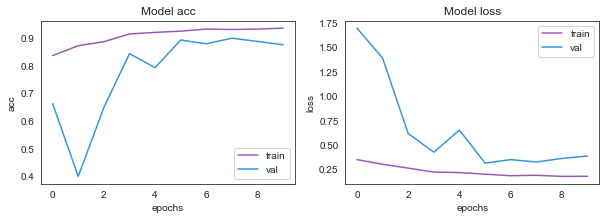

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, j in enumerate(['acc', 'loss']):
    ax[i].plot(final_model.history[j])
    ax[i].plot(final_model.history['val_' + j])
    ax[i].set_title('Model {}'.format(j))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(j)
    ax[i].legend(['train', 'val'])

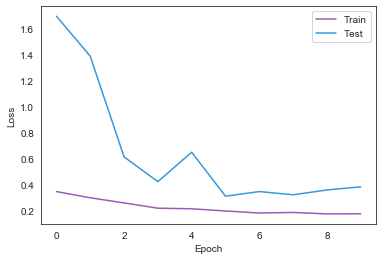

In [30]:
# Plot
def plot_loss(model):
    hist = pd.DataFrame(model.history)
    hist['epoch'] = model.epoch  
    plt.figure(figsize=(6, 4))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Test')
    plt.legend()
    plt.show()
    
plot_loss(final_model)

## Prediction

In [41]:
# Get prediction
prediction = model.predict(test_data_arrays)

acc = accuracy_score(test_labels, np.round(prediction))*100
cm = confusion_matrix(test_labels, np.round(prediction))

print('Acc: ', acc)
print('CM:' )
cm

Acc:  90.38461538461539
CM:


array([[376,  92],
       [ 28, 752]], dtype=int64)

## Evaluation Metrics

========= Confusion Matrix =========


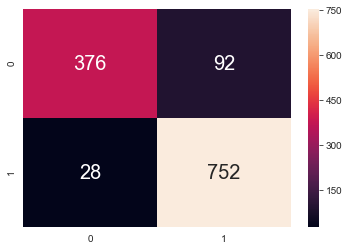


========= Evaluation Metrics =========
Accuracy: 90.385%
Precision: 93.069%
Recall: 80.342%
F1-score: 86.239

========= Training Accuracy =========
Train acc: 93.48


In [53]:
tn = cm[1][0]
fp = cm[1][0]
fn = cm[0][1]
tp = cm[0][0]

print('========= Confusion Matrix =========')
sns.heatmap(cm, 
            annot=True,
            fmt='d',
            annot_kws={'size': 20})
plt.show()

print('\n========= Evaluation Metrics =========')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {:.3f}%'.format(acc))
print('Precision: {:.3f}%'.format(precision))
print('Recall: {:.3f}%'.format(recall))
print('F1-score: {:.3f}'.format(2*precision*recall/(precision+recall)))

print('\n========= Training Accuracy =========')
print('Train acc: {}'.format(np.round((final_model.history['acc'][-1])*100, 2)))